<a href="https://colab.research.google.com/github/praveentn/hgwxx7/blob/master/deeplearning/CNN_text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving agr_en_dev.csv to agr_en_dev (1).csv
Saving agr_en_fb_test.csv to agr_en_fb_test (1).csv
Saving agr_en_sm_test.csv to agr_en_sm_test (1).csv
Saving agr_en_train.csv to agr_en_train (1).csv
Saving agr_hi_fb_test.csv to agr_hi_fb_test (1).csv
Saving agr_hi_sm_test.csv to agr_hi_sm_test (1).csv
User uploaded file "agr_en_dev.csv" with length 509412 bytes
User uploaded file "agr_en_fb_test.csv" with length 175256 bytes
User uploaded file "agr_en_sm_test.csv" with length 144618 bytes
User uploaded file "agr_en_train.csv" with length 2121862 bytes
User uploaded file "agr_hi_fb_test.csv" with length 349915 bytes
User uploaded file "agr_hi_sm_test.csv" with length 216605 bytes


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2019-09-03 06:43:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-09-03 06:43:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-09-03 06:43:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Libraries

In [0]:
import pandas as pd
import numpy as np
import time

from keras import layers, optimizers , initializers, callbacks
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.utils import plot_model
from keras import regularizers

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os


%matplotlib inline

In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded["agr_en_train.csv"]),encoding='UTF-8',names = ["text","aggression-level"],index_col=0)
test_df = pd.read_csv(io.BytesIO(uploaded["agr_en_dev.csv"]),encoding='UTF-8',names = ["text","aggression-level"],index_col=0)
df.head()

,text,aggression-level
facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,OAG
facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",OAG
facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,OAG
facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",NAG


In [6]:
#Labels Percentage
df["aggression-level"].value_counts(1)

NAG    0.420952
CAG    0.353363
OAG    0.225685
Name: aggression-level, dtype: float64

### Variables

In [0]:
RANDOM_STATE = 42
TEST_SIZE = 0.15

SEQ_LENGTH = 100 # After analyzing sequence lengths of the text, and few test, found that the usage fo SEQ_LENGTH equal to 100 covers most of the cases. Actually,  100 is placed on 97.8 percentile of  sequence length distribution.  
MAX_WORDS = 8000 # Text vocabulary size is 21545. But many of this words are used only once in all text. I choose maxwords to be 8 in order to exclude most of the words that have been used only once. 

EMBEDDING_DIM =  100 # this value will be benchmanrked.

#### Text preprocessing

In [0]:

X = df["text"]

encoder = LabelBinarizer()
Y = encoder.fit_transform(df["aggression-level"])
y_test = encoder.transform(test_df["aggression-level"])

text_train, text_valid, y_train, y_valid = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [0]:
# Tokenize and transform to integer index
tokenizer = Tokenizer(num_words=MAX_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r')
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_valid = tokenizer.texts_to_sequences(text_valid)
X_test = tokenizer.texts_to_sequences(test_df["text"])

In [0]:

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index

if not SEQ_LENGTH:
  SEQ_LENGTH = max(len(x) for x in X_train) # longest text in train set


# Add pading to ensure all vectors have same dimensionality
X_train = pad_sequences(X_train, padding='post',truncating='post', maxlen=SEQ_LENGTH)
X_valid = pad_sequences(X_valid, padding='post',truncating='post',maxlen=SEQ_LENGTH)
X_test = pad_sequences(X_test, padding='post',truncating='post',maxlen=SEQ_LENGTH)

In [11]:

print('Shape of train label tensor:', y_train.shape)
print('Shape of valid data tensor:', X_valid.shape)
print('Shape of valid label tensor:', y_valid.shape)

Shape of train label tensor: (10199, 3)
Shape of valid data tensor: (1800, 100)
Shape of valid label tensor: (1800, 3)


In [12]:
print('Tokenizer vocabulary size:', vocab_size)


Tokenizer vocabulary size: 21545


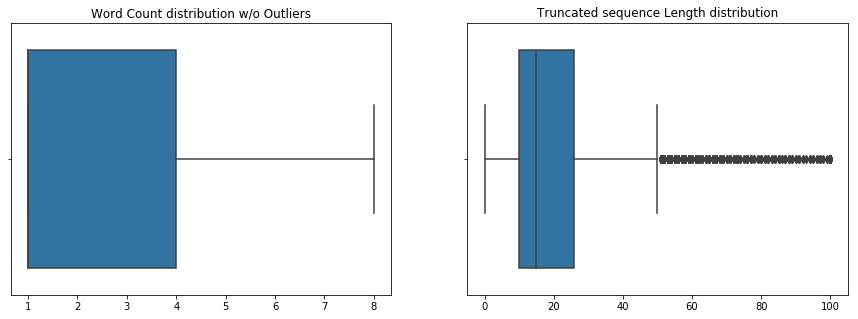

In [13]:
#Word count and sequence length distributions

word_count = [v for k,v in tokenizer.word_counts.items()]
seq_lenght_list = [len(x[x!=0]) for x in X_train]
#_= plt.hist(word_count, bins=100)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
_ = sns.boxplot(word_count, showfliers=False, ax=ax1)
ax1.set_title("Word Count distribution w/o Outliers")
_ = sns.boxplot(seq_lenght_list, ax=ax2)
_ = ax2.set_title("Truncated sequence Length distribution")


# Embedding Layer


In [14]:
def get_embedding_matrix(path,word_index,verbose=False):
  embeddings_index = {}
  f = open(path)
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()

  pretrainded_embedded_words= 0
  random_embedded_words= 0

  embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # we found the word - add that words vector to the matrix
          embedding_matrix[i] = embedding_vector
          pretrainded_embedded_words+=1
      else:
          # doesn't exist, assign a random vector
          embedding_matrix[i] = np.random.randn(EMBEDDING_DIM)
          random_embedded_words+=1
  
  if verbose>0:
    print("Embedding_matrix shape:", embedding_matrix.shape)
    print("Pretrainded embedded words:", pretrainded_embedded_words)
    print("Random embedded words:", random_embedded_words) 
  
  
  return embedding_matrix
        

 
  

embedding_matrix = get_embedding_matrix('./glove.6B.%sd.txt'%(EMBEDDING_DIM), word_index,verbose=True)

Embedding_matrix shape: (21545, 100)
Pretrainded embedded words: 15643
Random embedded words: 5901


In [15]:
embedding_matrix.shape

(21545, 100)

## **CNN MODELS DEFINITIONS**

In [0]:
# Define CNN architecture


def model_1(max_features, embedding_dim = 100, seqlen = None, embedding_matrix = None, train_embedding=False):
    
    """
    Sequential sigle layer CNN model using fixed filter size on Conv layer. SGD optimizer with moderate learning rate
    """
    #define the usage of pretrained embedding or randowm weight to be trained. 
    if type(embedding_matrix) != type(None):
      ENB_INIT= initializers.Constant(embedding_matrix)
    else:
      ENB_INIT='uniform'
    
    
    model = Sequential()
    model.add(layers.Embedding(max_features, embedding_dim, input_length=seqlen,embeddings_initializer = ENB_INIT,trainable=train_embedding))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    opt = optimizers.SGD(lr=0.01, momentum=0.8, decay=1e-6)
    model.compile(optimizer = opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def model_2(max_features,num_filters=128 ,kernel_sizes =[5], embedding_dim = 100, seqlen = None, embedding_matrix = None,train_embedding=False):
    """
    Sequential Deep CNN model using different filter size on Conv layers. SGD optimizer with moderate learning rate
    
    """
    #define the usage of pretrained embedding or randowm weight to be trained. 
    if type(embedding_matrix) != type(None):
      ENB_INIT= initializers.Constant(embedding_matrix)
    else:
      ENB_INIT='uniform'
    
    
    model = Sequential()
    model.add(layers.Embedding(max_features, embedding_dim, input_length=seqlen,embeddings_initializer = ENB_INIT,trainable=train_embedding))
    
    for ks in kernel_sizes[:-1]:
      model.add(layers.Conv1D(num_filters, ks, activation='relu'))
      model.add(layers.MaxPooling1D())
    
    model.add(layers.Conv1D(num_filters, kernel_sizes[-1], activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    opt = optimizers.SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

  

def model_3(max_features,num_filters=128 ,kernel_sizes =[5], embedding_dim = 100, seqlen = None, embedding_matrix = None,train_embedding=False):
  
    """
    Sequential 2 layer CNN model using fixed filter size on Conv layer. SGD optimizer with low learning rate. More epochs for trainig are needed for the model
    to converge. 
    """
    #define the usage of pretrained embedding or randowm weight to be trained. 
    if type(embedding_matrix) != type(None):
      ENB_INIT= initializers.Constant(embedding_matrix)
    else:
      ENB_INIT='uniform'
    
    
    model = Sequential()
    model.add(layers.Embedding(max_features, embedding_dim, input_length=seqlen,embeddings_initializer = ENB_INIT,trainable=train_embedding))
    model.add(layers.Conv1D(num_filters, 7, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(num_filters, 7, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(units = 3 , activation='softmax'))
    opt = optimizers.SGD(lr=1e-4, momentum=0.8, decay=0.0, nesterov=False)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    return model  

              
              
  
  
def parallel_1D(max_features, num_filters,kernel_sizes,embedding_dim = 100, seqlen = None, embedding_matrix = None, train_embedding=False):
  
    """
    Parallel Deep CNN model using different filter size on Conv layers. Adam optimizer
    
    """  
    
    #define the usage of pretrained embedding or randowm weight to be trained. 
    if type(embedding_matrix) != type(None):
      ENB_INIT= initializers.Constant(embedding_matrix)
    else:
      ENB_INIT='uniform'
      
    
    inputs = layers.Input(shape=(seqlen,), dtype='int32')
    
    # embedding layer
    embedding_layer = layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=seqlen,embeddings_initializer = ENB_INIT,trainable=train_embedding)(inputs)


    convets = []
    
    for ks in kernel_sizes:
      conv = layers.Conv1D(num_filters, ks, activation='relu', kernel_regularizer=regularizers.l2(3))(embedding_layer)
      maxpool = layers.MaxPooling1D(pool_size = 2)(conv)
      drop = layers.Dropout(0.5)(maxpool)
      convets.append(drop)
      
    # concat and flatten
    concatenated_tensor = layers.Concatenate(axis=1)(convets)
    flatten = layers.Flatten()(concatenated_tensor)

    # dropout 
    dropout = layers.Dropout(0.5)(flatten)
    output = layers.Dense(units=3, activation='softmax')(dropout)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model




#model = model_1(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, embedding_matrix = embedding_matrix)
#model = model_2(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, embedding_matrix = embedding_matrix,num_filters=128,kernel_sizes=[3,4,5])
#model = parallel_2D(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, num_filters=128,kernel_sizes=[3,4,5], embedding_matrix = embedding_matrix)
#model = parallel_1D(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, num_filters=128,kernel_sizes=[3,4,5], embedding_matrix = embedding_matrix)
#print(model.summary())

In [26]:
# Testing cell for a single Model

model = model_3(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, embedding_matrix = embedding_matrix,num_filters=128,kernel_sizes=[3,4,5] , train_embedding=False)

history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_valid, y_valid),
                    batch_size=32, shuffle=True)



loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 10199 samples, validate on 1800 samples
Epoch 1/100
10199/10199 [==============================] - 3s 293us/step - loss: 1.0843 - acc: 0.4196 - val_loss: 1.0598 - val_acc: 0.4500
Epoch 2/100
10199/10199 [==============================] - 2s 191us/step - loss: 1.0677 - acc: 0.4318 - val_loss: 1.0493 - val_acc: 0.4494
Epoch 3/100
10199/10199 [==============================] - 2s 202us/step - loss: 1.0619 - acc: 0.4350 - val_loss: 1.0445 - val_acc: 0.4528
Epoch 4/100
10199/10199 [==============================] - 2s 205us/step - loss: 1.0578 - acc: 0.4372 - val_loss: 1.0400 - val_acc: 0.4517
Epoch 5/100
10199/10199 [==============================] - 2s 206us/step - loss: 1.0540 - acc: 0.4406 - val_loss: 1.0360 - val_acc: 0.4572
Epoch 6/100
10199/10199 [==============================] - 2s 204us/step - loss: 1.0505 - acc: 0.4436 - val_loss: 1.0342 - val_acc: 0.4594
Epoch 7/100
10199/10199 [==============================] - 2s 206us/step - loss: 1.0469 - acc: 0.4485 - val_loss: 1.0

### Plotting functions

In [0]:
import seaborn as sns

def plot_class_probs(X,y,model,filename=None):
  
  BW = 0.01
  n_class = y.shape[1]
  fig, axes = plt.subplots(2,n_class,figsize=(15,10))

  probs = model.predict(X)
  for i in range(n_class):
    p = probs[:,i]
    sns.kdeplot(p[y[:,i]==1],color="r", ax= axes[0][i], label="positive",bw=BW)
    sns.kdeplot(p[y[:,i]==0],color="b", ax= axes[0][i], label="negative",bw=BW)
    axes[0][i].set_title("Class Label: %s"%encoder.classes_[i])
    
    #cumulative
    sns.kdeplot(p[y[:,i]==1],color="r", ax= axes[1][i], label="positive", cumulative=True,bw=BW)
    sns.kdeplot(p[y[:,i]==0],color="b", ax= axes[1][i], label="negative", cumulative=True,bw=BW)
    axes[1][i].set_title("Class Label: %s"%encoder.classes_[i])

  fig.tight_layout()
  
  if filename:
      fig.savefig(filename,bbox_inches="tight")


In [0]:
def plot_history(history, filename = None):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    axes[0].plot(x, acc, 'b', label='Training acc')
    axes[0].plot(x, val_acc, 'r', label='Validation acc')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend()
    axes[1].plot(x, loss, 'b', label='Training loss')
    axes[1].plot(x, val_loss, 'r', label='Validation loss')
    axes[1].set_title('Training and validation loss')
    axes[1].legend()
    
    if filename:
      fig.savefig(filename,bbox_inches="tight")
    



## Models Benchmarking

### Models Set up

In [0]:
import itertools
models_dict = {}

for EMBEDDING_DIM,use_pretrained in  itertools.product([50, 100, 200],[True,False]):


  
  if use_pretrained:
    embedding_matrix = get_embedding_matrix('./glove.6B.%sd.txt'%(EMBEDDING_DIM),word_index= word_index)
  else:
    embedding_matrix = None
  
  #Model 1
  param_dict ={}
  model_name = "SS_CNN_1D_EBD{}_PTE_{}".format(EMBEDDING_DIM, str(use_pretrained)[0])
  param_dict["model"] = model_1(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, embedding_matrix = embedding_matrix , train_embedding= not use_pretrained)
  param_dict["epoch"] = 30
  models_dict[model_name] = param_dict
  
  #Model 2
  param_dict ={}
  model_name = "SD_CNN_1D_EBD{}_PTE_{}".format(EMBEDDING_DIM, str(use_pretrained)[0])
  param_dict["model"] = model_2(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, embedding_matrix = embedding_matrix,num_filters=128,kernel_sizes=[3,5,7],train_embedding= not use_pretrained)
  param_dict["epoch"] = 30
  models_dict[model_name] = param_dict
  
  #Model 3
  param_dict ={}
  model_name = "SB_CNN_1D_EBD{}_PTE_{}".format(EMBEDDING_DIM, str(use_pretrained)[0])
  param_dict["model"] = model_3(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, embedding_matrix = embedding_matrix,num_filters=32,train_embedding= not use_pretrained)
  param_dict["epoch"] = 200
  models_dict[model_name] = param_dict
  
  #Model 4
  param_dict ={}
  model_name = "PD_CNN_1D_EBD{}_PTE_{}".format(EMBEDDING_DIM, str(use_pretrained)[0])
  param_dict["model"] = parallel_1D(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, num_filters=128,kernel_sizes=[3,4,5], embedding_matrix = embedding_matrix,train_embedding= not use_pretrained)
  param_dict["epoch"] = 10
  models_dict[model_name] = param_dict
  
  


### Models Train

SS_CNN_1D_EBD50_PTE_T
SD_CNN_1D_EBD50_PTE_T
SB_CNN_1D_EBD50_PTE_T
PD_CNN_1D_EBD50_PTE_T
SS_CNN_1D_EBD50_PTE_F
SD_CNN_1D_EBD50_PTE_F
SB_CNN_1D_EBD50_PTE_F
PD_CNN_1D_EBD50_PTE_F
SS_CNN_1D_EBD100_PTE_T
SD_CNN_1D_EBD100_PTE_T
SB_CNN_1D_EBD100_PTE_T
PD_CNN_1D_EBD100_PTE_T
SS_CNN_1D_EBD100_PTE_F
SD_CNN_1D_EBD100_PTE_F
SB_CNN_1D_EBD100_PTE_F
PD_CNN_1D_EBD100_PTE_F
SS_CNN_1D_EBD200_PTE_T
SD_CNN_1D_EBD200_PTE_T
SB_CNN_1D_EBD200_PTE_T
PD_CNN_1D_EBD200_PTE_T


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


SS_CNN_1D_EBD200_PTE_F


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


SD_CNN_1D_EBD200_PTE_F


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


SB_CNN_1D_EBD200_PTE_F


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


PD_CNN_1D_EBD200_PTE_F


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


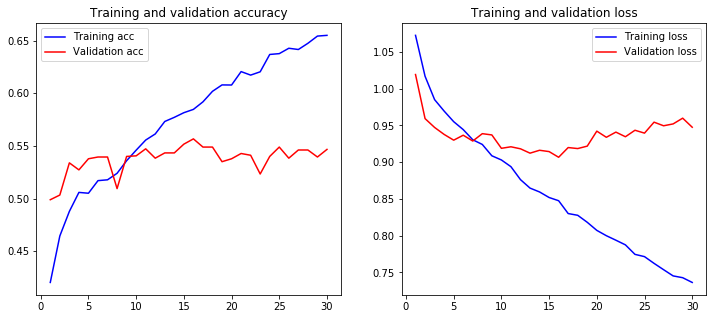

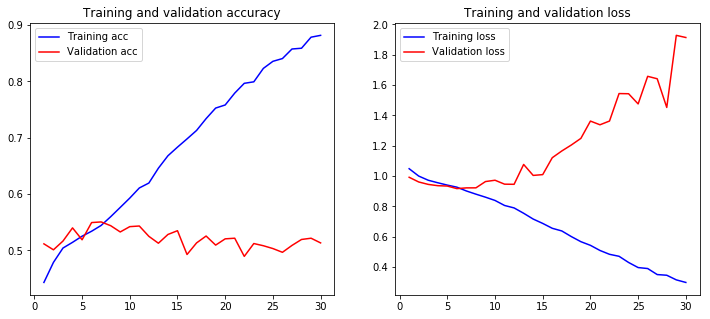

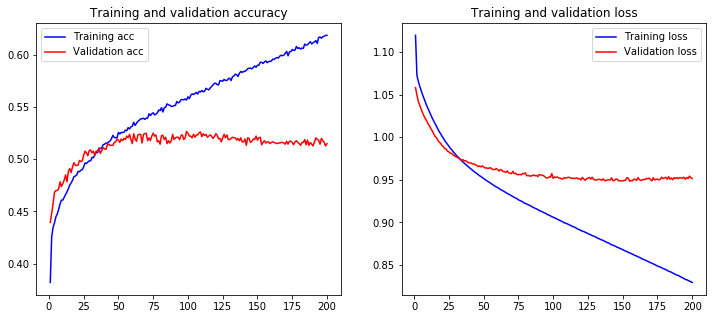

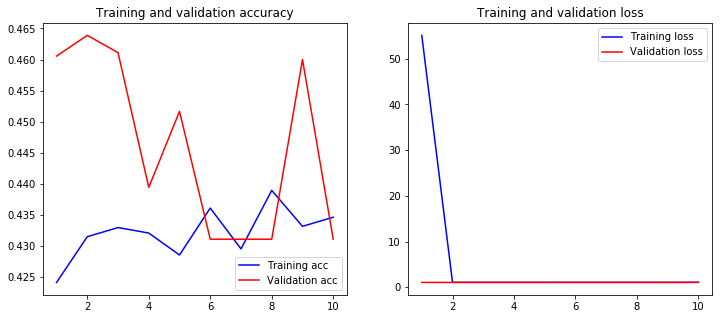

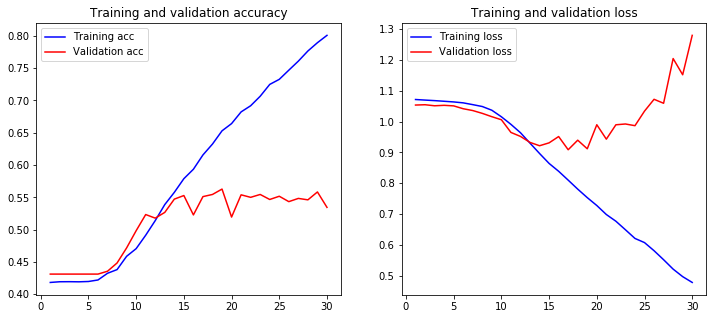

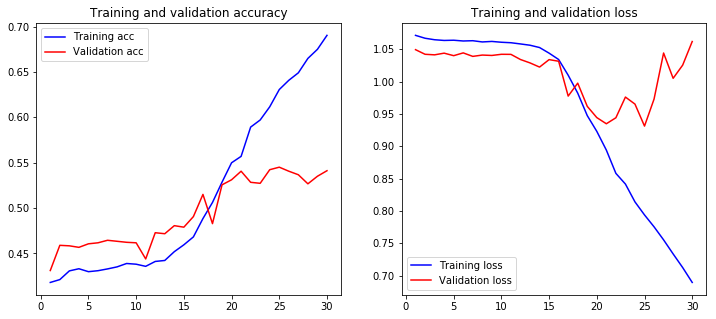

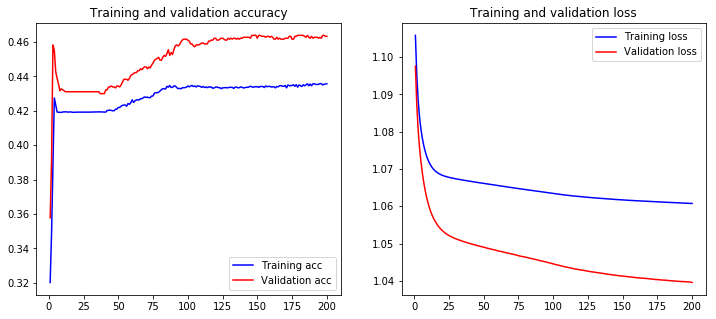

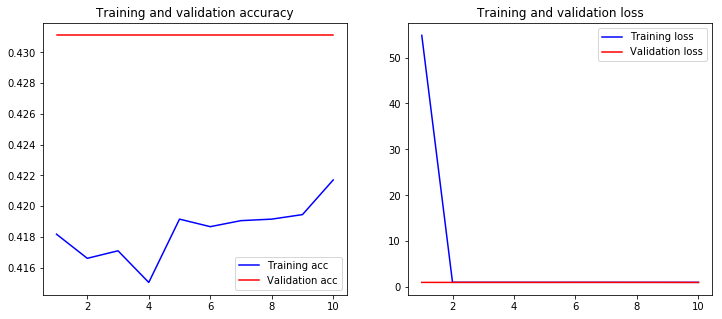

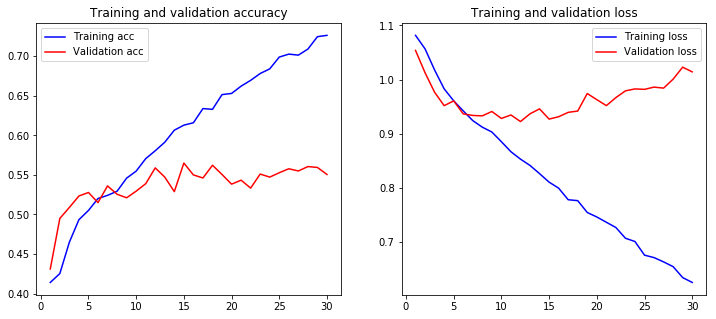

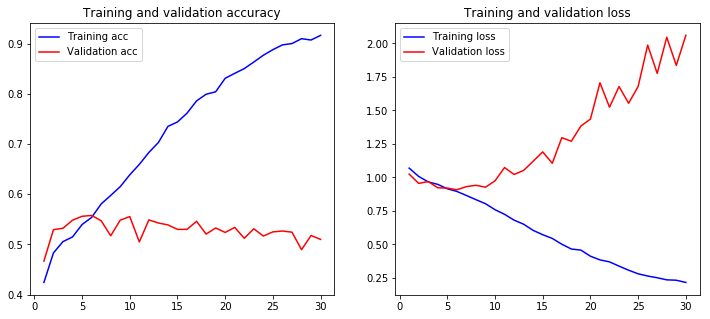

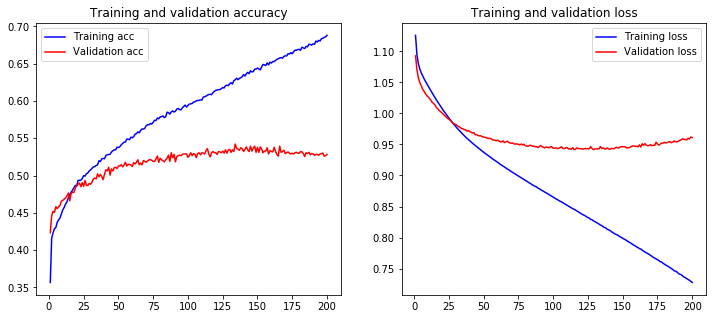

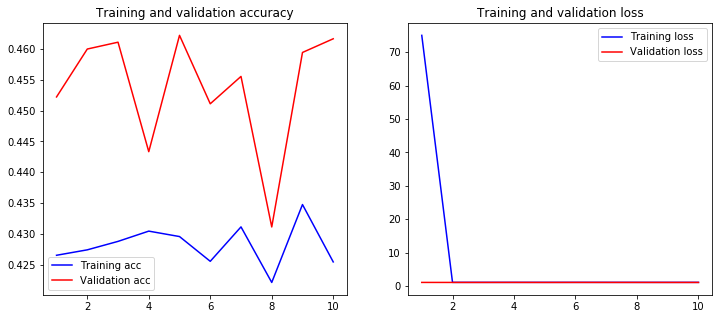

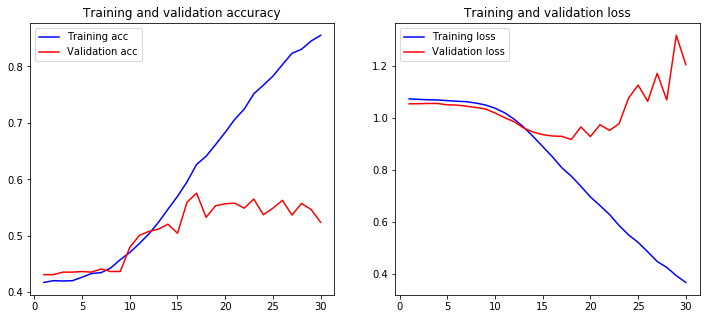

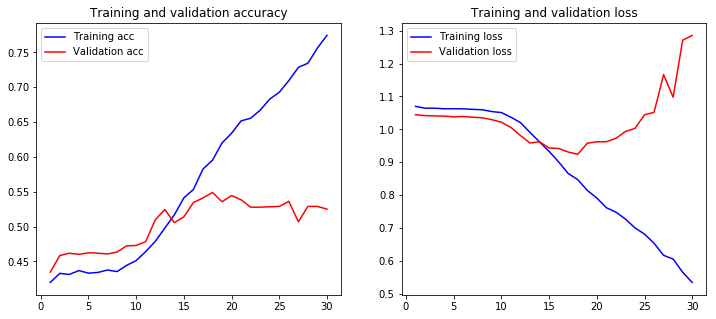

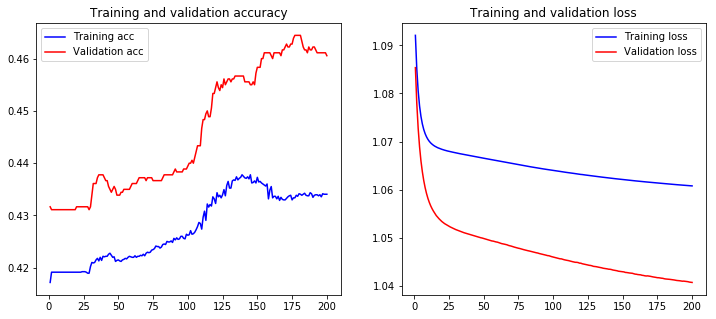

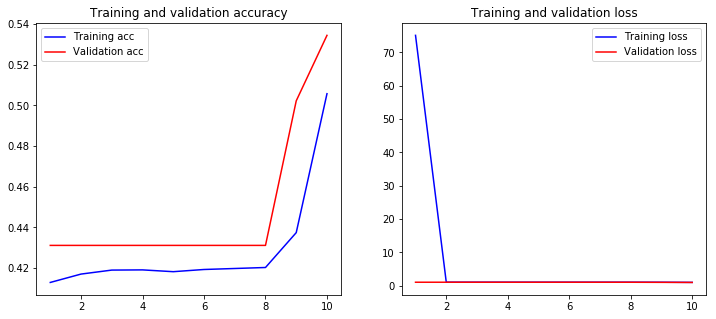

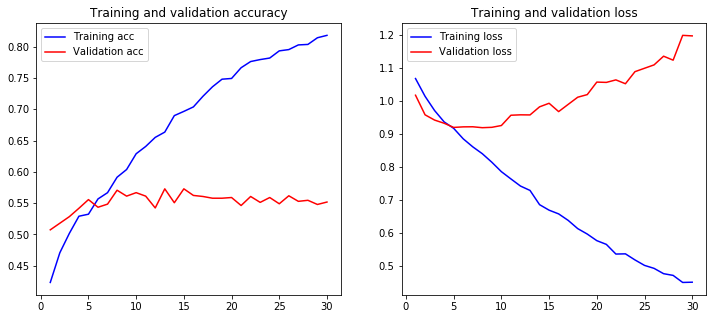

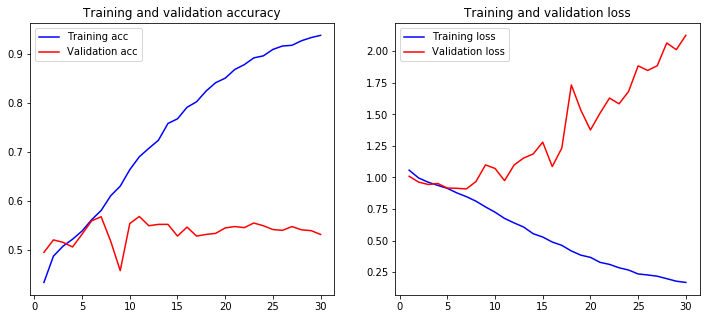

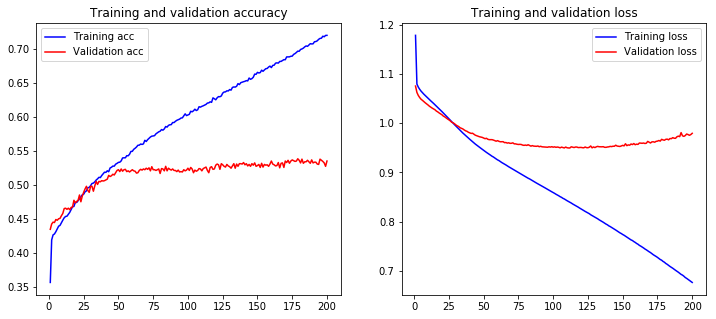

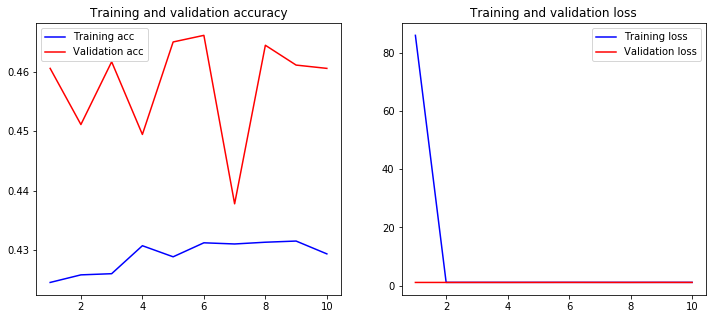

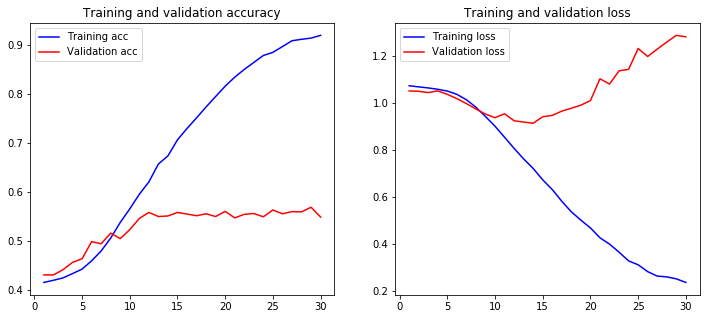

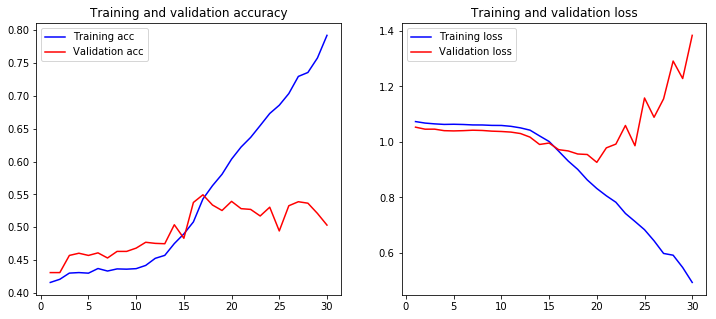

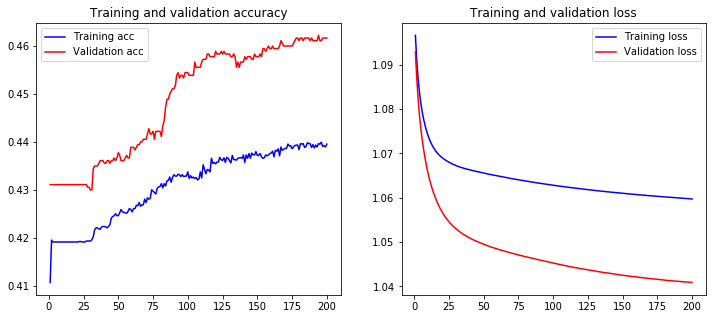

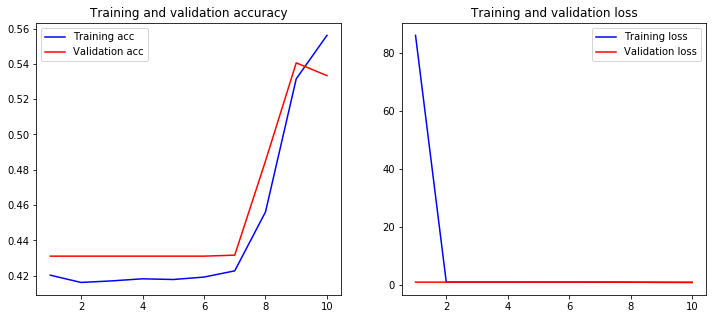

In [30]:
for k in models_dict.keys():
  print(k)
  os.makedirs("./results/{0}".format(k), exist_ok=True)
  os.makedirs("./BestModels/{0}".format(k), exist_ok=True)
  
  save_best_callback = callbacks.ModelCheckpoint("./BestModels/{0}/best_model.h5".format(k), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
  
  model  = models_dict[k]
  model["history"] = model["model"].fit(X_train, y_train,
                    epochs=model["epoch"],
                    verbose=False,
                    validation_data=(X_valid, y_valid),
                    batch_size=32, shuffle=True,
                    callbacks=[save_best_callback])
  
  loss, accuracy = model["model"].evaluate(X_train, y_train, verbose=False)
  model["Training Accuracy"]= accuracy
  loss, accuracy = model["model"].evaluate(X_valid, y_valid, verbose=False)
  model["Validation Accuracy"]= accuracy
  
  history = model["history"]
  #best epoch
  model["Best Valid epoch"] = np.argmax(history.history['val_acc']) + 1
  #max accuracy
  model["Best Valid accuracy"] = np.max(history.history['val_acc'])
  #Top 3 accuracy mean
  model["Top3 Valid accuracy mean"] = np.mean(np.sort(history.history['val_acc'])[-3:])
  #Top 3 accuracy std
  model["Top3 Valid accuracy std"] = np.std(np.sort(history.history['val_acc'])[-3:])
  
  #max accuracy
  model["Best Train accuracy"] = np.max(history.history['acc'])
  
  plot_history(history,filename="./results/{0}/{0}_train_progress.jpg".format(k))
  plot_class_probs(X_valid,y_valid, model["model"],filename="./results/{0}/{0}_valid_probs.jpg".format(k))
  plot_model(model["model"],to_file="./results/{0}/{0}_model.jpg".format(k),show_shapes=True)
  
  plt.close()
  
  

### Benchmark Analysis

In [31]:
import pandas as pd
benchmark_df = pd.DataFrame([{"Model Name":k,
  "Best Valid epoch" : d["Best Valid epoch"],
  "Best Valid accuracy":d["Best Valid accuracy"],
  "Top3 Valid accuracy mean":d["Top3 Valid accuracy mean"],
  "Top3 Valid accuracy std":d["Top3 Valid accuracy std"],
  "Best Train accuracy":d["Best Train accuracy"],
  "Train epoch" : d["epoch"],
  "Embedding Dimensions" : k.split("_")[3][3:],
  "Pre Trained embedings" : {"F":False,"T":True}.get(k.split("_")[-1][-1])
 
 
 }  for k,d in models_dict.items()])[["Model Name","Embedding Dimensions","Pre Trained embedings","Train epoch","Best Valid epoch","Best Train accuracy","Best Valid accuracy","Top3 Valid accuracy mean","Top3 Valid accuracy std"]].sort_values("Best Valid accuracy", ascending=False)

benchmark_df.to_excel("./results/benchmark_results.xlsx", index=False)

benchmark_df

,Model Name,Embedding Dimensions,Pre Trained embedings,Train epoch,Best Valid epoch,Best Train accuracy,Best Valid accuracy,Top3 Valid accuracy mean,Top3 Valid accuracy std
12,SS_CNN_1D_EBD100_PTE_F,100,False,30,17,0.855084,0.575556,0.567778,5.574043e-03
16,SS_CNN_1D_EBD200_PTE_T,200,True,30,13,0.818217,0.572778,0.572037,1.047566e-03
20,SS_CNN_1D_EBD200_PTE_F,200,False,30,29,0.919012,0.568889,0.564259,3.464498e-03
17,SD_CNN_1D_EBD200_PTE_T,200,True,30,11,0.938131,0.568333,0.565185,4.065648e-03
8,SS_CNN_1D_EBD100_PTE_T,100,True,30,15,0.726444,0.565000,0.562593,1.833240e-03
4,SS_CNN_1D_EBD50_PTE_F,50,False,30,19,0.800863,0.562778,0.558519,3.404588e-03
9,SD_CNN_1D_EBD100_PTE_T,100,True,30,6,0.917247,0.557778,0.556481,9.442629e-04
0,SS_CNN_1D_EBD50_PTE_T,50,True,30,16,0.654966,0.556667,0.552407,3.218175e-03
1,SD_CNN_1D_EBD50_PTE_T,50,True,30,7,0.881655,0.550556,0.547963,2.916299e-03
21,SD_CNN_1D_EBD200_PTE_F,200,False,30,17,0.791940,0.549444,0.542593,4.850297e-03


#### Pre Trained embedding impact

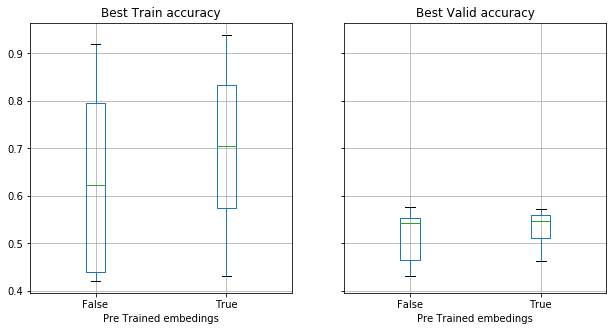

In [32]:
benchmark_df.boxplot(column=["Best Train accuracy","Best Valid accuracy"],by="Pre Trained embedings", figsize=(10,5), return_type=None)
_=plt.suptitle("")


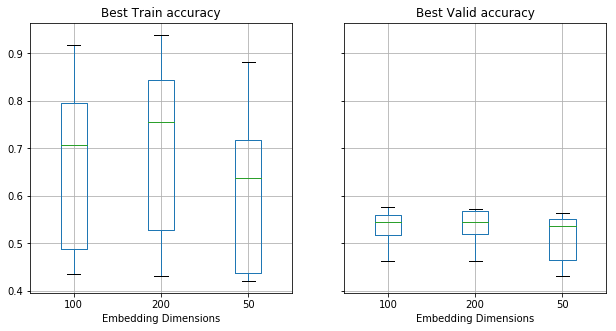

In [33]:
benchmark_df.boxplot(column=["Best Train accuracy","Best Valid accuracy"],by="Embedding Dimensions", figsize=(10,5), return_type=None)
_=plt.suptitle("")

#### Top 3 Models Traning Analysis

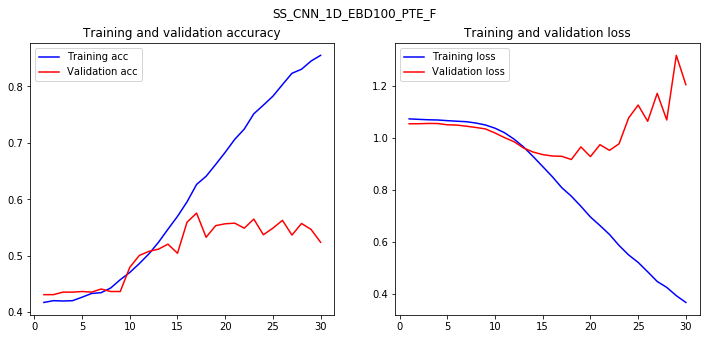

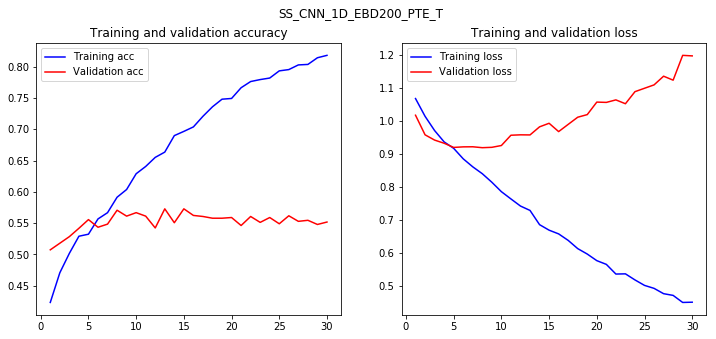

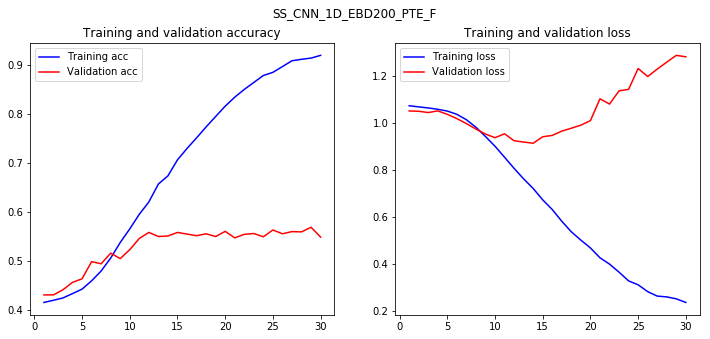

In [34]:
for model_name in benchmark_df.iloc[:3,0].tolist():
  #print(model_name)
  plot_history(models_dict[model_name]["history"])
  plt.suptitle(model_name)
  plt.show()
  plt.close()

#### Top 3 Models Test set Class prediction probabilities distribution



###### SS_CNN_1D_EBD100_PTE_F #####


              precision    recall  f1-score   support

         CAG       0.43      0.52      0.47      1057
         NAG       0.59      0.77      0.67      1233
         OAG       0.66      0.11      0.19       711

    accuracy                           0.53      3001
   macro avg       0.56      0.47      0.44      3001
weighted avg       0.55      0.53      0.49      3001



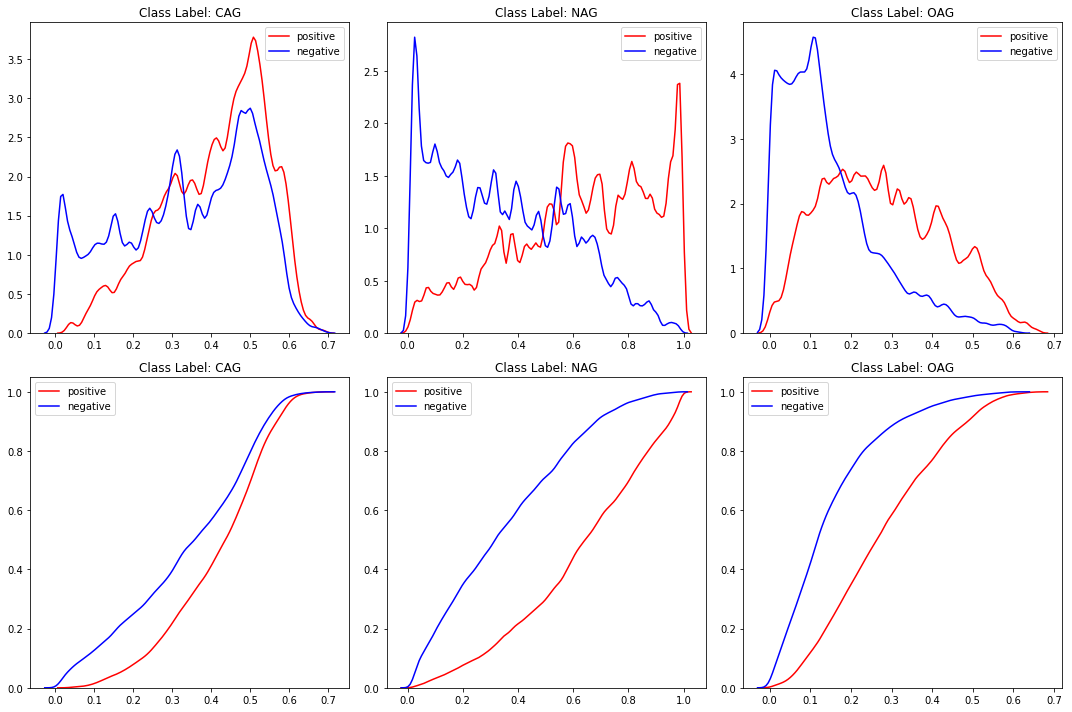



###### SS_CNN_1D_EBD200_PTE_T #####


              precision    recall  f1-score   support

         CAG       0.44      0.61      0.51      1057
         NAG       0.65      0.67      0.66      1233
         OAG       0.60      0.21      0.31       711

    accuracy                           0.54      3001
   macro avg       0.56      0.50      0.49      3001
weighted avg       0.56      0.54      0.52      3001



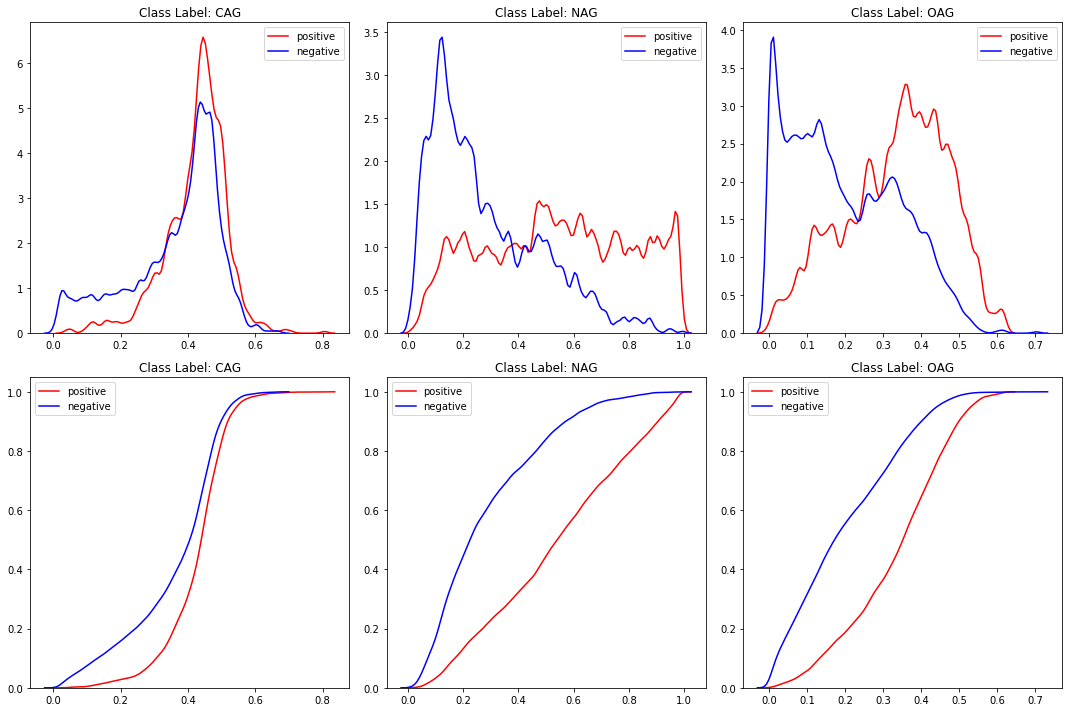



###### SS_CNN_1D_EBD200_PTE_F #####


              precision    recall  f1-score   support

         CAG       0.44      0.55      0.49      1057
         NAG       0.60      0.70      0.65      1233
         OAG       0.62      0.19      0.30       711

    accuracy                           0.53      3001
   macro avg       0.55      0.48      0.48      3001
weighted avg       0.55      0.53      0.51      3001



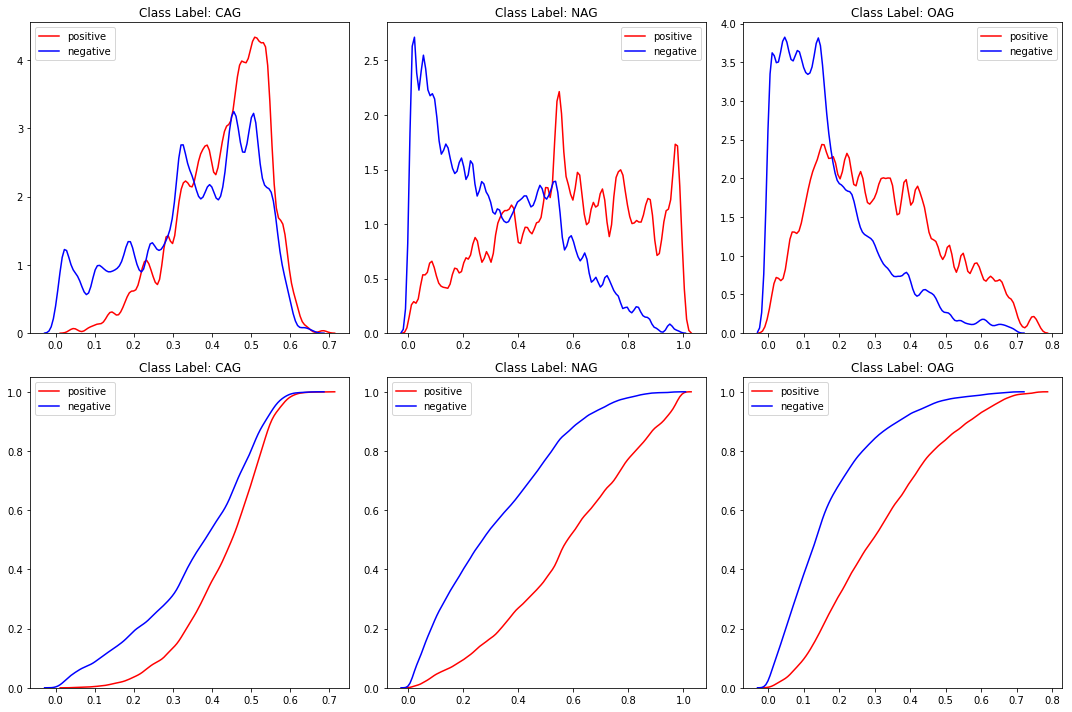

In [35]:
for model_name in benchmark_df.iloc[:3,0].tolist():
  #print(model_name)
  print("\n\n###### %s #####\n\n"%(model_name))
  best_model =  load_model("./BestModels/{0}/best_model.h5".format(model_name))
  
  X_temp = X_test
  y_temp = y_test
  
  y_true = [encoder.classes_[i] for i in  np.argmax(y_temp,1)]
  y_pred = [encoder.classes_[i] for i in np.argmax(best_model.predict(X_temp),1)]
  print(classification_report(y_true,y_pred))
  
  
  
  plot_class_probs(X_temp,y_temp, best_model)
  plt.show()
  plt.close()
  

## Submit predictions

In [36]:
# text preprocessing
# Tokenize and transform to integer index

text_all = pd.concat([df["text"],test_df["text"]])
y_all = pd.concat([df["aggression-level"],test_df["aggression-level"]])

tokenizer = Tokenizer(num_words=MAX_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r')
tokenizer.fit_on_texts(text_all)

X_all = tokenizer.texts_to_sequences(text_all)
X_all = pad_sequences(X_all, padding='post',truncating='post', maxlen=SEQ_LENGTH)

encoder = LabelBinarizer()
y_all = encoder.fit_transform(y_all)


print("X_full shape:{}\ty_train shape:{}".format(X_all.shape,y_all.shape))

X_full shape:(15000, 100)	y_train shape:(15000, 3)


In [0]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  


In [38]:
# Final Training on SS_CNN_1D_EBD100_PTE_T with all data
EMBEDDING_DIM = 100
use_pretrained = True
embedding_matrix = get_embedding_matrix('./glove.6B.%sd.txt'%(EMBEDDING_DIM),word_index= word_index)
model = model_1(embedding_dim = EMBEDDING_DIM, seqlen = SEQ_LENGTH, max_features = vocab_size, embedding_matrix = embedding_matrix , train_embedding= not use_pretrained)

history = model.fit(X_all, y_all,
                    epochs=10,
                    verbose=1,
                    validation_split=0.15,
                    batch_size=32, shuffle=True)

Train on 12750 samples, validate on 2250 samples
Epoch 1/10
12750/12750 [==============================] - 5s 418us/step - loss: 1.0618 - acc: 0.4285 - val_loss: 1.0120 - val_acc: 0.4791
Epoch 2/10
12750/12750 [==============================] - 2s 195us/step - loss: 1.0013 - acc: 0.4814 - val_loss: 0.9861 - val_acc: 0.5053
Epoch 3/10
12750/12750 [==============================] - 2s 195us/step - loss: 0.9689 - acc: 0.5047 - val_loss: 0.9496 - val_acc: 0.5031
Epoch 4/10
12750/12750 [==============================] - 3s 197us/step - loss: 0.9475 - acc: 0.5211 - val_loss: 0.9283 - val_acc: 0.5324
Epoch 5/10
12750/12750 [==============================] - 2s 196us/step - loss: 0.9254 - acc: 0.5318 - val_loss: 0.9260 - val_acc: 0.5178
Epoch 6/10
12750/12750 [==============================] - 3s 197us/step - loss: 0.9091 - acc: 0.5413 - val_loss: 0.9167 - val_acc: 0.5347
Epoch 7/10
12750/12750 [==============================] - 3s 196us/step - loss: 0.8946 - acc: 0.5517 - val_loss: 0.9160 - v

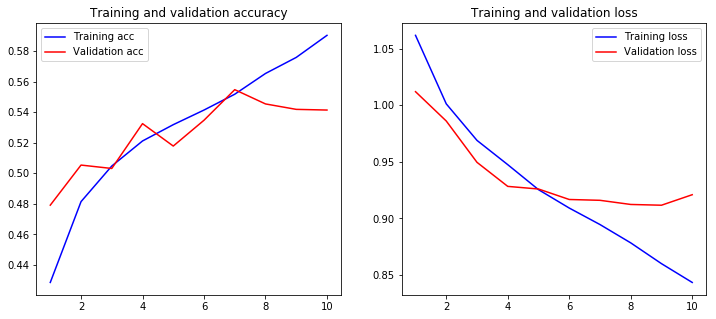

In [39]:
plot_history(history)
plt.show()
plt.close()

In [0]:
#Load Datasets

df_dict = {}


file_Names = ["agr_en_fb_test.csv","agr_en_sm_test.csv","agr_hi_fb_test.csv","agr_hi_sm_test.csv"]

for filename  in file_Names:
  df_dict[filename.split(".")[0]] = pd.read_csv(io.BytesIO(uploaded[filename]),encoding='UTF-8',names = ["text"],index_col=0)


In [41]:
# Predict
 os.makedirs("./Predictions/", exist_ok=True)
for k in df_dict.keys():
  print(k)
  sub_df = df_dict[k]
  X_sub = pad_sequences(tokenizer.texts_to_sequences(sub_df["text"]), padding='post',truncating='post', maxlen=SEQ_LENGTH)
  df_dict[k]["aggression-level"] = [encoder.classes_[i] for i in np.argmax(model.predict(X_sub),1)]
  df_dict[k].to_csv("./Predictions/%s_prediction.csv"%(k),header=False)

agr_en_fb_test
agr_en_sm_test
agr_hi_fb_test
agr_hi_sm_test


In [42]:
!zip -r Predictions.zip Predictions

  adding: Predictions/ (stored 0%)
  adding: Predictions/agr_hi_sm_test_prediction.csv (deflated 65%)
  adding: Predictions/agr_en_fb_test_prediction.csv (deflated 59%)
  adding: Predictions/agr_en_sm_test_prediction.csv (deflated 58%)
  adding: Predictions/agr_hi_fb_test_prediction.csv (deflated 69%)


In [43]:
files.download("Predictions.zip")

MessageError: ignored